# Food101 Conformal Model Wrapper

Wraps the base ViT classifier with conformal prediction using RAPS (Regularized Adaptive Prediction Sets).

**Base Model**: Vision Transformer fine-tuned on Food101  
**Conformal Method**: RAPS algorithm with regularization  
**Target Coverage**: 90% (alpha=0.1)  
**Framework**: MLflow PyFunc wrapper

**Flow**: Image → Base ViT → Softmax Scores → RAPS → Prediction Sets

## Install Dependencies

In [0]:
%pip install transformers torch torchvision pillow numpy pandas scikit-learn matplotlib accelerate --quiet
dbutils.library.restartPython()

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


## Configuration

In [0]:
import mlflow
import os

os.environ['HF_HOME'] = '/tmp/huggingface'
os.environ['TRANSFORMERS_CACHE'] = '/tmp/huggingface/transformers'
os.environ['TORCH_HOME'] = '/tmp/torch'
os.environ['TMPDIR'] = '/tmp'

CATALOG = "jdub_demo_aws"
SCHEMA = "food101"
TABLE_NAME = "bronze_images"
BASE_MODEL_NAME = "food101_cv_classifier"
CONFORMAL_MODEL_NAME = "food101_cv_conformal"
FULL_TABLE_NAME = f"{CATALOG}.{SCHEMA}.{TABLE_NAME}"

ALPHA = 0.1
LAM_REG = 0.01
K_REG = 5
MAX_SET_SIZE = 6
MAX_CALIBRATION_SAMPLES = 5050
MAX_VAL_SAMPLES = 5050

mlflow.set_tracking_uri("databricks")
mlflow.set_experiment(f"/Users/{spark.sql('SELECT current_user()').collect()[0][0]}/food101_conformal_wrapper")

print(f"Config: {FULL_TABLE_NAME}")
print(f"Base Model: {CATALOG}.{SCHEMA}.{BASE_MODEL_NAME}")
print(f"Target Coverage: {1-ALPHA:.1%} | RAPS: lambda={LAM_REG}, k={K_REG} | Max Set: {MAX_SET_SIZE}")

Config: jdub_demo_aws.food101.bronze_images
Base Model: jdub_demo_aws.food101.food101_cv_classifier
Target Coverage: 90.0% | RAPS: lambda=0.01, k=5 | Max Set: 6


## Load Base Model from Unity Catalog

In [0]:
import mlflow.transformers

model_uri = f"models:/{CATALOG}.{SCHEMA}.{BASE_MODEL_NAME}/2"
base_model = mlflow.transformers.load_model(model_uri)

print(f"Base model loaded: {type(base_model)}")

## Load Calibration Data

In [0]:
from pyspark.sql import functions as F
import io
from PIL import Image
import numpy as np

df_calibration = spark.table(FULL_TABLE_NAME).filter(F.col("split") == "calibration").limit(MAX_CALIBRATION_SAMPLES)
calibration_data = df_calibration.select("image_bytes", "label_id", "label").toPandas()

food_classes_df = spark.table(FULL_TABLE_NAME).select("label_id", "label").distinct().orderBy("label_id")
food_classes = [row['label'] for row in food_classes_df.collect()]
NUM_CLASSES = len(food_classes)

test_img = Image.open(io.BytesIO(calibration_data.iloc[0]['image_bytes'])).convert('RGB')
test_preds = base_model(test_img)

label_id_to_name = None
if test_preds[0]['label'].startswith('LABEL_'):
    label_id_to_name = {row['label_id']: row['label'] for row in food_classes_df.collect()}

print(f"Calibration samples: {len(calibration_data)} | Classes: {NUM_CLASSES}")

Calibration samples: 5050 | Classes: 101


## Generate Calibration Scores

In [0]:
cal_images = []
cal_labels = []

for idx in range(len(calibration_data)):
    try:
        img_bytes = calibration_data.iloc[idx]['image_bytes']
        image = Image.open(io.BytesIO(img_bytes)).convert('RGB')
        cal_images.append(image)
        cal_labels.append(calibration_data.iloc[idx]['label_id'])
    except:
        continue

all_scores = []
for image in cal_images:
    preds = base_model(image)
    score_array = np.zeros(NUM_CLASSES)
    
    for pred in preds:
        pred_label = pred['label']
        pred_score = pred['score']
        
        if pred_label.startswith('LABEL_') and label_id_to_name is not None:
            label_id = int(pred_label.split('_')[1])
            food_name = label_id_to_name.get(label_id)
            if food_name and food_name in food_classes:
                j = food_classes.index(food_name)
                score_array[j] = pred_score
        else:
            if pred_label in food_classes:
                j = food_classes.index(pred_label)
                score_array[j] = pred_score
    
    all_scores.append(score_array)

cal_smx = np.array(all_scores)
cal_labels = np.array(cal_labels)

print(f"Calibration scores: {cal_smx.shape}")

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Calibration scores: (5050, 101)


## Compute RAPS Conformal Quantile

In [0]:
n = cal_smx.shape[0]
reg_vec = np.array(K_REG*[0,] + (NUM_CLASSES-K_REG)*[LAM_REG,])[None,:]

cal_pi = cal_smx.argsort(1)[:,::-1]
cal_srt = np.take_along_axis(cal_smx, cal_pi, axis=1)
cal_srt_reg = cal_srt + reg_vec
cal_L = np.where(cal_pi == cal_labels[:,None])[1]
cal_scores = cal_srt_reg.cumsum(axis=1)[np.arange(n), cal_L] - np.random.rand(n) * cal_srt_reg[np.arange(n), cal_L]
qhat = np.quantile(cal_scores, np.ceil((n+1)*(1-ALPHA))/n, interpolation='higher')

print(f"RAPS calibration complete | n={n} | qhat={qhat:.4f}")

RAPS calibration complete | n=5050 | qhat=0.9340


## Create Conformal PyFunc Wrapper

In [0]:
import mlflow.pyfunc
import pandas as pd

class ConformalViTWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self, base_model, qhat, lam_reg, k_reg, max_set_size, food_classes, label_id_to_name=None):
        self.base_model = base_model
        self.qhat = qhat
        self.lam_reg = lam_reg
        self.k_reg = k_reg
        self.max_set_size = max_set_size
        self.food_classes = food_classes
        self.num_classes = len(food_classes)
        self.reg_vec = np.array(k_reg*[0,] + (self.num_classes-k_reg)*[lam_reg,])[None,:]
        self.label_id_to_name = label_id_to_name
    
    def predict(self, context, model_input):
        import io
        from PIL import Image
        import numpy as np

        results = []
        if isinstance(model_input, pd.DataFrame):
            images = [Image.open(io.BytesIO(img_bytes)).convert('RGB') for img_bytes in model_input['image_bytes']]
        else:
            images = model_input

        for image in images:
            preds = self.base_model(image)
            score_array = np.zeros(self.num_classes)
            
            for pred in preds:
                pred_label = pred['label']
                pred_score = pred['score']
                
                if pred_label.startswith('LABEL_') and self.label_id_to_name is not None:
                    label_id = int(pred_label.split('_')[1])
                    food_name = self.label_id_to_name.get(label_id)
                    if food_name and food_name in self.food_classes:
                        idx = self.food_classes.index(food_name)
                        score_array[idx] = pred_score
                else:
                    if pred_label in self.food_classes:
                        idx = self.food_classes.index(pred_label)
                        score_array[idx] = pred_score

            smx = score_array[None,:]
            pi = smx.argsort(1)[:,::-1]
            srt = np.take_along_axis(smx, pi, axis=1)
            srt_reg = srt + self.reg_vec
            srt_reg_cumsum = srt_reg.cumsum(axis=1)

            indicators = (srt_reg_cumsum - np.random.rand(1,1) * srt_reg) <= self.qhat
            indicators[:,0] = True
            prediction_set_mask = np.take_along_axis(indicators, pi.argsort(axis=1), axis=1)[0]

            if prediction_set_mask.sum() > self.max_set_size:
                in_set = np.where(prediction_set_mask)[0]
                scores_in_set = score_array[in_set]
                top_k_indices = in_set[np.argsort(scores_in_set)[-self.max_set_size:]]
                prediction_set_mask = np.zeros(self.num_classes, dtype=bool)
                prediction_set_mask[top_k_indices] = True

            pred_set_indices = np.where(prediction_set_mask)[0]
            pred_set_labels = [self.food_classes[i] for i in pred_set_indices]
            pred_set_scores = [float(score_array[i]) for i in pred_set_indices]

            top_idx = np.argmax(score_array)
            results.append({
                'prediction_set': pred_set_labels,
                'prediction_scores': pred_set_scores,
                'set_size': len(pred_set_labels),
                'top_prediction': self.food_classes[top_idx],
                'top_score': float(score_array[top_idx])
            })

        return pd.DataFrame(results)

/databricks/python/lib/python3.12/site-packages/mlflow/pyfunc/utils/data_validation.py:186: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(


## Register Conformal Model to Unity Catalog

In [0]:
from mlflow.models import infer_signature

conformal_model = ConformalViTWrapper(
    base_model=base_model,
    qhat=qhat,
    lam_reg=LAM_REG,
    k_reg=K_REG,
    max_set_size=MAX_SET_SIZE,
    food_classes=food_classes,
    label_id_to_name=label_id_to_name
)

sample_input = pd.DataFrame({'image_bytes': [calibration_data.iloc[0]['image_bytes']]})
sample_output = conformal_model.predict(None, sample_input)
signature = infer_signature(sample_input, sample_output)

with mlflow.start_run(run_name="conformal_wrapper_registration") as run:
    mlflow.log_params({
        "alpha": ALPHA,
        "target_coverage": 1-ALPHA,
        "qhat": float(qhat),
        "lam_reg": LAM_REG,
        "k_reg": K_REG,
        "max_set_size": MAX_SET_SIZE,
        "calibration_samples": n
    })
    
    model_info = mlflow.pyfunc.log_model(
        artifact_path="conformal_model",
        python_model=conformal_model,
        registered_model_name=f"{CATALOG}.{SCHEMA}.{CONFORMAL_MODEL_NAME}",
        signature=signature,
        pip_requirements=["mlflow", "transformers", "torch", "torchvision", "pillow", "numpy", "pandas"]
    )
    
    print(f"Model registered: {CATALOG}.{SCHEMA}.{CONFORMAL_MODEL_NAME}")
    print(f"Coverage: {1-ALPHA:.1%} | qhat: {qhat:.4f}")

/databricks/python/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/databricks/python/lib/python3.12/site-packages/mlflow/pyfunc/__init__.py:3212: UserWarning: An input example was not provided when logging the model. To ensure the model signature functions correctly, specify the `input_example` parameter.

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Registered model 'jdub_demo_aws.food101.food101_cv_conformal' already exists. Creating a new version of this model...


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Model registered: jdub_demo_aws.food101.food101_cv_conformal
Coverage: 90.0% | qhat: 0.9340


Created version '9' of model 'jdub_demo_aws.food101.food101_cv_conformal'.


## Quick Test

In [0]:
test_df = spark.table(FULL_TABLE_NAME).filter(F.col("split") == "test").limit(10)
test_data = test_df.select("image_bytes", "label_id", "label").toPandas()

loaded_model = mlflow.pyfunc.load_model(model_info.model_uri)
test_predictions = loaded_model.predict(pd.DataFrame({'image_bytes': test_data['image_bytes'].tolist()}))

coverage = sum([test_data.iloc[i]['label'] in test_predictions.iloc[i]['prediction_set'] for i in range(len(test_data))])
print(f"Coverage: {coverage}/{len(test_data)} ({coverage/len(test_data):.1%}) | Avg set size: {test_predictions['set_size'].mean():.2f}")

Coverage: 9/10 (90.0%) | Avg set size: 1.70


## Full Validation Evaluation

In [0]:
df_validation = spark.table(FULL_TABLE_NAME).filter(F.col("split") == "test").limit(MAX_VAL_SAMPLES)
val_data = df_validation.select("image_bytes", "label_id", "label").toPandas()

input_df = pd.DataFrame({'image_bytes': val_data['image_bytes'].tolist()})
predictions = loaded_model.predict(input_df)

true_labels = val_data['label'].tolist()
coverage_results = [true_labels[i] in predictions.iloc[i]['prediction_set'] for i in range(len(predictions))]
empirical_coverage = np.mean(coverage_results)
avg_set_size = predictions['set_size'].mean()
median_set_size = np.median(predictions['set_size'])

print(f"\n{'='*60}")
print(f"CONFORMAL PREDICTION RESULTS")
print(f"{'='*60}")
print(f"Target Coverage: {1-ALPHA:.1%}")
print(f"Empirical Coverage: {empirical_coverage:.1%}")
print(f"Coverage Gap: {empirical_coverage - (1-ALPHA):+.1%}")
print(f"Average Set Size: {avg_set_size:.2f}")
print(f"Median Set Size: {median_set_size:.0f}")
print(f"Validation Samples: {len(val_data)}")
print(f"{'='*60}")


CONFORMAL PREDICTION RESULTS
Target Coverage: 90.0%
Empirical Coverage: 91.8%
Coverage Gap: +1.8%
Average Set Size: 1.80
Median Set Size: 1
Validation Samples: 5050


## Visualizations

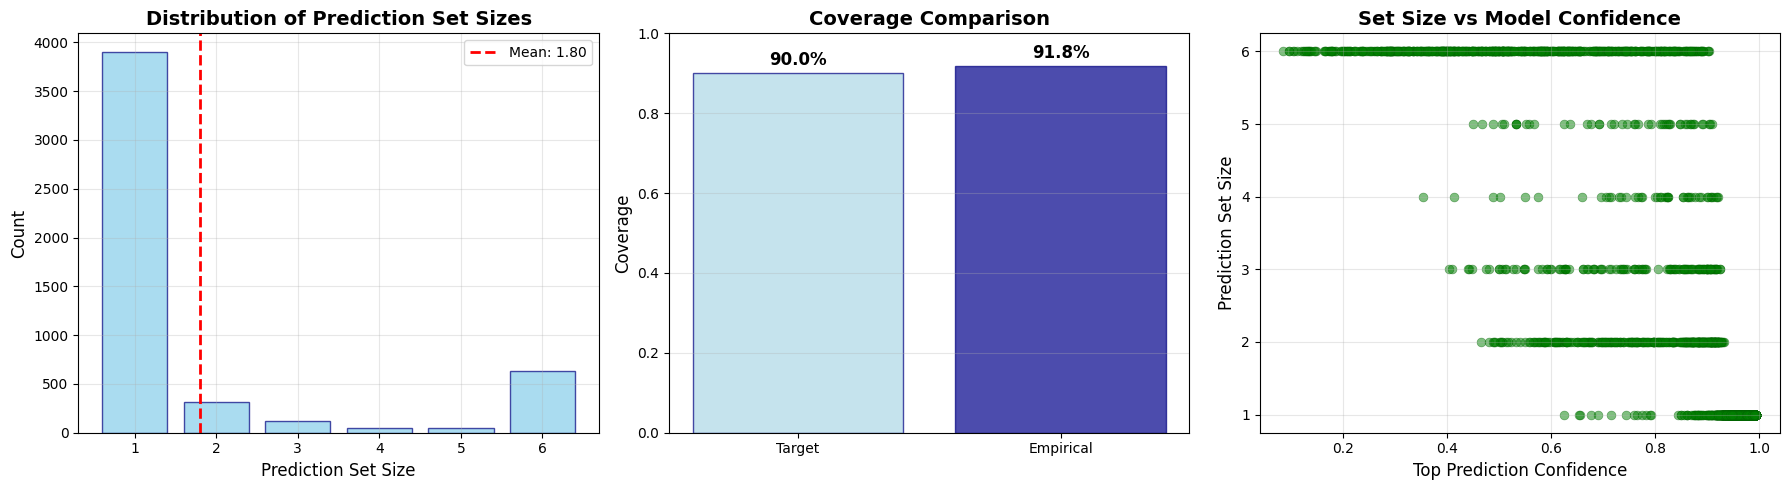


KEY METRICS
Set Size Range: 1-6
Mean Set Size: 1.80
Median Set Size: 1
Single Predictions: 77.2%
≤3 Predictions: 85.7%


In [0]:
import matplotlib.pyplot as plt

set_sizes = predictions['set_size'].values
top_scores = predictions['top_score'].values
coverage_array = np.array(coverage_results)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Set size distribution
unique_sizes, size_counts = np.unique(set_sizes, return_counts=True)
axes[0].bar(unique_sizes, size_counts, color='skyblue', alpha=0.7, edgecolor='navy')
axes[0].axvline(avg_set_size, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_set_size:.2f}')
axes[0].set_xlabel('Prediction Set Size', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Distribution of Prediction Set Sizes', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Coverage comparison
bars = axes[1].bar(['Target', 'Empirical'], [1-ALPHA, empirical_coverage], 
                   color=['lightblue', 'darkblue'], alpha=0.7, edgecolor='navy')
for bar, value in zip(bars, [1-ALPHA, empirical_coverage]):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                 f'{value:.1%}', ha='center', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Coverage', fontsize=12)
axes[1].set_title('Coverage Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylim([0, 1])
axes[1].grid(True, alpha=0.3, axis='y')

# 3. Set size vs confidence
axes[2].scatter(top_scores, set_sizes, alpha=0.5, color='green', s=40, edgecolors='darkgreen', linewidth=0.5)
axes[2].set_xlabel('Top Prediction Confidence', fontsize=12)
axes[2].set_ylabel('Prediction Set Size', fontsize=12)
axes[2].set_title('Set Size vs Model Confidence', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

corr = np.corrcoef(top_scores, set_sizes)[0,1]
print(f"\n{'='*60}")
print(f"KEY METRICS")
print(f"{'='*60}")
print(f"Set Size Range: {set_sizes.min():.0f}-{set_sizes.max():.0f}")
print(f"Mean Set Size: {set_sizes.mean():.2f}")
print(f"Median Set Size: {np.median(set_sizes):.0f}")
print(f"Single Predictions: {(set_sizes == 1).mean():.1%}")
print(f"≤3 Predictions: {(set_sizes <= 3).mean():.1%}")
print(f"{'='*60}")

## Class Confusion Analysis: Similar Foods

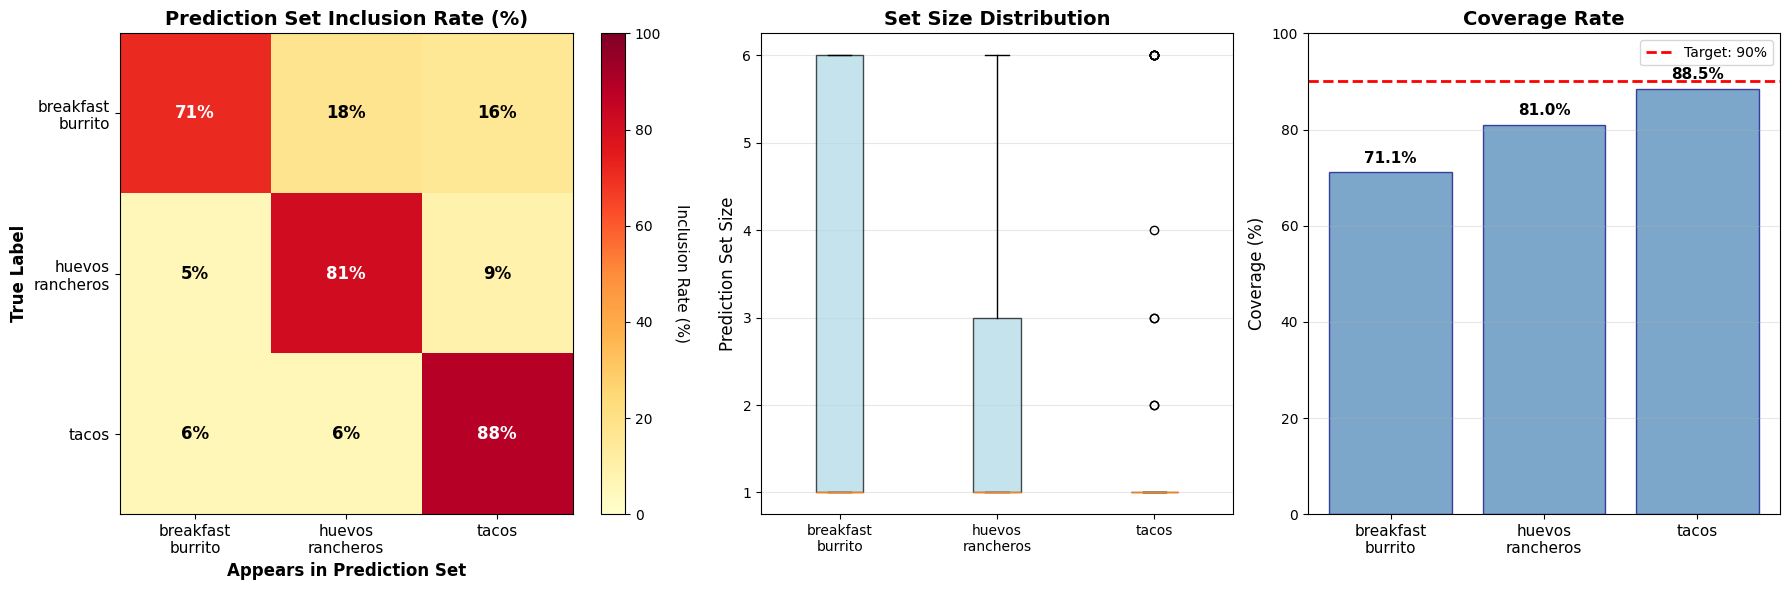


SIMILAR CLASSES ANALYSIS: breakfast_burrito, huevos_rancheros, tacos

BREAKFAST BURRITO:
  Samples: 45
  Coverage: 71.1%
  Avg Set Size: 2.51
  Confusion with:
    - huevos_rancheros: 17.8%
    - tacos: 15.6%

HUEVOS RANCHEROS:
  Samples: 58
  Coverage: 81.0%
  Avg Set Size: 2.38
  Confusion with:
    - tacos: 8.6%
    - breakfast_burrito: 5.2%

TACOS:
  Samples: 52
  Coverage: 88.5%
  Avg Set Size: 1.85
  Confusion with:
    - breakfast_burrito: 5.8%
    - huevos_rancheros: 5.8%


In [0]:
# Analyze similar food classes that might be confused
SIMILAR_CLASSES = ['breakfast_burrito', 'huevos_rancheros', 'tacos']

# Filter data for these classes
similar_mask = val_data['label'].isin(SIMILAR_CLASSES)
similar_data = val_data[similar_mask].reset_index(drop=True)
similar_predictions = predictions[similar_mask].reset_index(drop=True)
similar_coverage = coverage_array[similar_mask]

# Calculate confusion matrix for prediction sets
confusion_data = []
for true_class in SIMILAR_CLASSES:
    class_mask = similar_data['label'] == true_class
    class_preds = similar_predictions[class_mask]
    
    for pred_class in SIMILAR_CLASSES:
        # Count how many times pred_class appears in prediction sets
        count = sum([pred_class in pred_set for pred_set in class_preds['prediction_set']])
        confusion_data.append({
            'true': true_class,
            'predicted': pred_class,
            'count': count,
            'total': class_mask.sum()
        })

# Create visualization
fig = plt.figure(figsize=(18, 6))
gs = fig.add_gridspec(1, 3, width_ratios=[1.2, 1, 1])

# 1. Confusion heatmap for prediction set inclusion
ax1 = fig.add_subplot(gs[0])
confusion_matrix = np.zeros((len(SIMILAR_CLASSES), len(SIMILAR_CLASSES)))
for i, true_class in enumerate(SIMILAR_CLASSES):
    for j, pred_class in enumerate(SIMILAR_CLASSES):
        item = [d for d in confusion_data if d['true'] == true_class and d['predicted'] == pred_class][0]
        confusion_matrix[i, j] = item['count'] / item['total'] * 100 if item['total'] > 0 else 0

im = ax1.imshow(confusion_matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=100)
ax1.set_xticks(range(len(SIMILAR_CLASSES)))
ax1.set_yticks(range(len(SIMILAR_CLASSES)))
ax1.set_xticklabels([c.replace('_', '\n') for c in SIMILAR_CLASSES], fontsize=11)
ax1.set_yticklabels([c.replace('_', '\n') for c in SIMILAR_CLASSES], fontsize=11)
ax1.set_xlabel('Appears in Prediction Set', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax1.set_title('Prediction Set Inclusion Rate (%)', fontsize=14, fontweight='bold')

# Add text annotations
for i in range(len(SIMILAR_CLASSES)):
    for j in range(len(SIMILAR_CLASSES)):
        text_color = 'white' if confusion_matrix[i, j] > 50 else 'black'
        ax1.text(j, i, f'{confusion_matrix[i, j]:.0f}%', 
                ha='center', va='center', color=text_color, fontweight='bold', fontsize=12)

# Add colorbar
cbar = plt.colorbar(im, ax=ax1)
cbar.set_label('Inclusion Rate (%)', rotation=270, labelpad=20, fontsize=11)

# 2. Set size distribution by class
ax2 = fig.add_subplot(gs[1])
set_sizes_by_class = [similar_predictions[similar_data['label'] == c]['set_size'].values 
                       for c in SIMILAR_CLASSES]
bp = ax2.boxplot(set_sizes_by_class, labels=[c.replace('_', '\n') for c in SIMILAR_CLASSES],
                  patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_alpha(0.7)
ax2.set_ylabel('Prediction Set Size', fontsize=12)
ax2.set_title('Set Size Distribution', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# 3. Coverage by class
ax3 = fig.add_subplot(gs[2])
coverage_by_class = [similar_coverage[similar_data['label'] == c].mean() * 100 
                     for c in SIMILAR_CLASSES]
bars = ax3.bar(range(len(SIMILAR_CLASSES)), coverage_by_class, color='steelblue', alpha=0.7, edgecolor='navy')
ax3.axhline(y=(1-ALPHA)*100, color='red', linestyle='--', linewidth=2, label=f'Target: {(1-ALPHA)*100:.0f}%')
ax3.set_xticks(range(len(SIMILAR_CLASSES)))
ax3.set_xticklabels([c.replace('_', '\n') for c in SIMILAR_CLASSES], fontsize=11)
ax3.set_ylabel('Coverage (%)', fontsize=12)
ax3.set_title('Coverage Rate', fontsize=14, fontweight='bold')
ax3.set_ylim([0, 100])
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# Add values on bars
for i, (bar, value) in enumerate(zip(bars, coverage_by_class)):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
             f'{value:.1f}%', ha='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n{'='*70}")
print(f"SIMILAR CLASSES ANALYSIS: {', '.join(SIMILAR_CLASSES)}")
print(f"{'='*70}")
for i, true_class in enumerate(SIMILAR_CLASSES):
    class_mask = similar_data['label'] == true_class
    class_preds = similar_predictions[class_mask]
    class_cov = similar_coverage[class_mask].mean()
    avg_size = class_preds['set_size'].mean()
    
    # Find most common confusions
    other_classes = [c for c in SIMILAR_CLASSES if c != true_class]
    confusion_rates = {
        c: sum([c in pred_set for pred_set in class_preds['prediction_set']]) / len(class_preds) * 100
        for c in other_classes
    }
    
    print(f"\n{true_class.upper().replace('_', ' ')}:")
    print(f"  Samples: {class_mask.sum()}")
    print(f"  Coverage: {class_cov:.1%}")
    print(f"  Avg Set Size: {avg_size:.2f}")
    print(f"  Confusion with:")
    for conf_class, rate in sorted(confusion_rates.items(), key=lambda x: x[1], reverse=True):
        print(f"    - {conf_class}: {rate:.1f}%")
print(f"{'='*70}")

## Example Predictions by Uncertainty Level

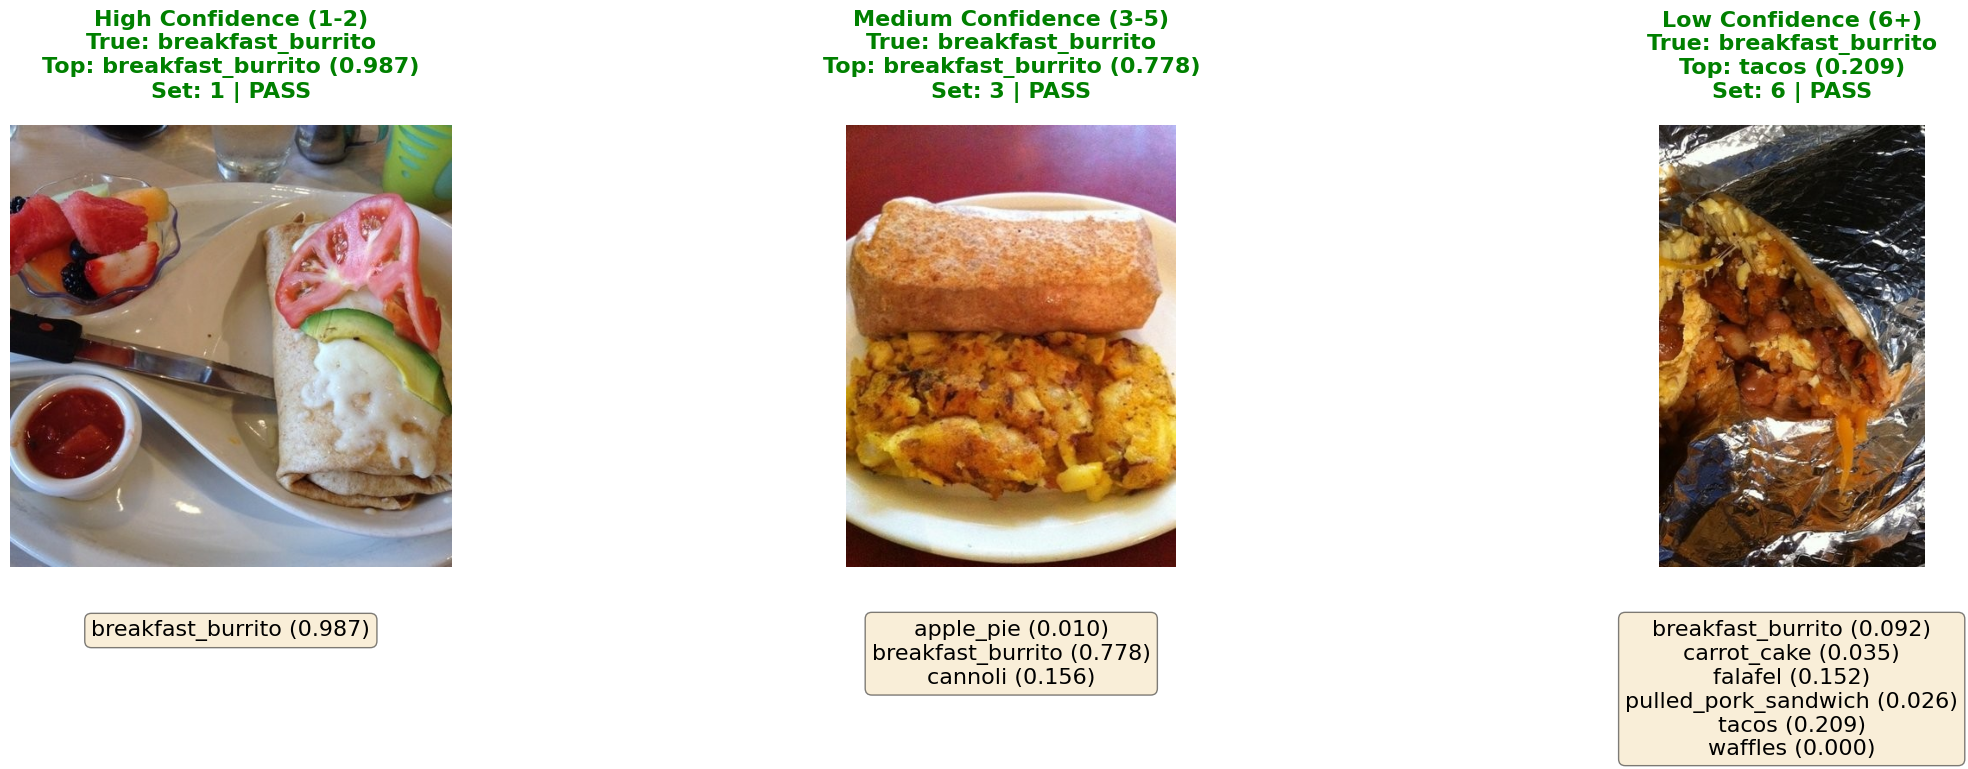


Class 'breakfast_burrito' stats:
  Samples: 45
  Coverage: 71.1%
  Avg Set Size: 2.51


In [0]:
# Filter by specific class (set to None to show random examples from each category)
TARGET_CLASS = "breakfast_burrito"  # Change this to any food class or set to None

size_categories = {"High Confidence (1-2)": (1, 2), "Medium Confidence (3-5)": (3, 5), "Low Confidence (6+)": (6, 50)}
examples = []

for name, (min_s, max_s) in size_categories.items():
    mask = (set_sizes >= min_s) & (set_sizes <= max_s)
    
    # Apply class filter if specified
    if TARGET_CLASS is not None:
        class_mask = val_data['label'] == TARGET_CLASS
        mask = mask & class_mask
    
    indices = np.where(mask)[0]
    if len(indices) > 0:
        examples.append((name, np.random.choice(indices)))
    else:
        print(f"No examples found for {name}" + (f" with class '{TARGET_CLASS}'" if TARGET_CLASS else ""))

if len(examples) == 0:
    print(f"No examples found" + (f" for class '{TARGET_CLASS}'" if TARGET_CLASS else ""))
else:
    fig, axes = plt.subplots(1, len(examples), figsize=(8*len(examples), 8))
    if len(examples) == 1:
        axes = [axes]

    for idx, (category, val_idx) in enumerate(examples):
        img = Image.open(io.BytesIO(val_data.iloc[val_idx]['image_bytes'])).convert('RGB')
        true_label = true_labels[val_idx]
        pred_set = predictions.iloc[val_idx]['prediction_set']
        pred_scores = predictions.iloc[val_idx]['prediction_scores']
        top_pred = predictions.iloc[val_idx]['top_prediction']
        top_score = predictions.iloc[val_idx]['top_score']
        is_covered = true_label in pred_set
        
        axes[idx].imshow(img)
        color = 'green' if is_covered else 'red'
        title = f"{category}\nTrue: {true_label}\nTop: {top_pred} ({top_score:.3f})\nSet: {len(pred_set)} | {'PASS' if is_covered else 'FAIL'}"
        axes[idx].set_title(title, fontsize=16, fontweight='bold', color=color, pad=20)
        
        set_text = "\n".join([f"{label} ({score:.3f})" for label, score in zip(pred_set[:6], pred_scores[:6])])
        if len(pred_set) > 6:
            set_text += f"\n...+{len(pred_set)-6} more"
        axes[idx].text(0.5, -0.12, set_text, fontsize=16, transform=axes[idx].transAxes,
                       va='top', ha='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()
    
    if TARGET_CLASS is not None:
        class_stats = val_data['label'] == TARGET_CLASS
        class_coverage = coverage_array[class_stats].mean() if class_stats.sum() > 0 else 0
        class_avg_size = set_sizes[class_stats].mean() if class_stats.sum() > 0 else 0
        print(f"\nClass '{TARGET_CLASS}' stats:")
        print(f"  Samples: {class_stats.sum()}")
        print(f"  Coverage: {class_coverage:.1%}")
        print(f"  Avg Set Size: {class_avg_size:.2f}")

## Deploy to Model Serving Endpoint

In [ ]:
from databricks.sdk import WorkspaceClient
from databricks.sdk.service.serving import EndpointCoreConfigInput, ServedEntityInput

ENDPOINT_NAME = "food101-cv-conformal-endpoint"
w = WorkspaceClient()

try:
    w.serving_endpoints.get(ENDPOINT_NAME)
    print(f"Endpoint '{ENDPOINT_NAME}' already exists")
except:
    w.serving_endpoints.create(
        name=ENDPOINT_NAME,
        config=EndpointCoreConfigInput(
            served_entities=[ServedEntityInput(
                entity_name=f"{CATALOG}.{SCHEMA}.{CONFORMAL_MODEL_NAME}",
                entity_version="9",  # Latest version with GPU support
                workload_size="GPU_SMALL",  # Use GPU Small for accelerated inference
                scale_to_zero_enabled=True
            )]
        )
    )
    print(f"Endpoint '{ENDPOINT_NAME}' created with GPU_SMALL")

print(f"\nEndpoint URL: https://{w.config.host}/serving-endpoints/{ENDPOINT_NAME}")

## Test Model Serving Endpoint

Test the deployed endpoint with a local image file using the Databricks ML serving pattern.

In [ ]:
import base64
import os
import requests
import json
from PIL import Image
import matplotlib.pyplot as plt

# Load local image file
LOCAL_IMAGE_PATH = "images/image.jpg"

with open(LOCAL_IMAGE_PATH, 'rb') as f:
    test_image_bytes = f.read()

# Display the image
test_image = Image.open(LOCAL_IMAGE_PATH)
plt.figure(figsize=(6, 6))
plt.imshow(test_image)
plt.axis('off')
plt.title(f"Test Image: {LOCAL_IMAGE_PATH}", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Convert to base64 for API request (required for JSON serialization)
test_image_b64 = base64.b64encode(test_image_bytes).decode('utf-8')

# Prepare request using Databricks ML Serving pattern
# Model signature expects 'image_bytes' as binary (base64-encoded in JSON)
endpoint_url = f"{w.config.host}/serving-endpoints/{ENDPOINT_NAME}/invocations"
headers = {
    'Authorization': f'Bearer {os.environ.get("DATABRICKS_TOKEN")}',
    'Content-Type': 'application/json'
}

# Use dataframe_split format for binary data
payload = {
    'dataframe_split': {
        'columns': ['image_bytes'],
        'data': [[test_image_b64]]
    }
}

print(f"\nTesting endpoint: {ENDPOINT_NAME}")
print(f"Image: {LOCAL_IMAGE_PATH}")
print(f"Endpoint URL: {endpoint_url}")
print(f"\nSending request...")

# Make prediction request
response = requests.post(endpoint_url, headers=headers, json=payload)

if response.status_code == 200:
    result = response.json()
    
    # Handle both response formats
    if 'predictions' in result:
        prediction = result['predictions'][0]
    else:
        prediction = result
    
    print(f"\n{'='*70}")
    print(f"ENDPOINT RESPONSE")
    print(f"{'='*70}")
    print(f"\nTop Prediction:")
    print(f"  Class: {prediction['top_prediction']}")
    print(f"  Confidence: {prediction['top_score']:.4f}")
    
    print(f"\nConformal Prediction Set (90% coverage guarantee):")
    print(f"  Set Size: {prediction['set_size']}")
    print(f"  Classes:")
    for class_name, score in zip(prediction['prediction_set'], prediction['prediction_scores']):
        print(f"    {class_name}: {score:.4f}")
    
    print(f"{'='*70}")
    
    # Show example API request format
    print(f"\n\nExample API Request Format:")
    print(json.dumps({
        "dataframe_split": {
            "columns": ["image_bytes"],
            "data": [["<base64-encoded-image-bytes>"]]
        }
    }, indent=2))
    
else:
    print(f"Error: {response.status_code}")
    print(response.text)